***
# Time-series analysis and volatility forecasting using functional-pipelines
***

<p style="text-align: right"><i>Jesus Perez Colino<br>First version: 25th Feb. 2021<br></i></p>

## About this notebook: 
****
Notebook prepared by **Jesus Perez Colino**. This work is licensed under a [Creative Commons Attribution-ShareAlike 3.0 Unported License](http://creativecommons.org/licenses/by-sa/3.0/deed.en_US). This work is offered for free, and it is not intended as a professional or financial advice.


- **Summary**: 

>This notebook aim to show a practical case of time-series analysis and volatility forecasting, throught the methodology and steps presented below, for the European Gas prices (front-month TTF future price in EUR/MWh), US gas prices (front-month Henry Hub future price in U.S. dollars and cents / MMBtu) and Brent price (front-month ICE future contract in U.S. dollars and cents / barrel). Please, notice that the goal of this notebook is not to build the perfect volaility model, but just to use these time series as excuse to build a time-series volatility model using the mentioned methodology. Or in simple words, this is not  the pro version of what a volatility-price forecasting model should be, just an approximation.

- **Index**: 

>1. Brief Methodology description
>2. Data Ingestion
>3. Data Exploration and understanding
>4. Data Preprocessing and Feature Engineering
>5. Model Building and Selection
>6. Model Forecasting and benchmarking
>7. Conclusions

- **Reporducibility conditions**: 

In [1]:
%matplotlib inline
%load_ext watermark
import os
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
from sklearn import preprocessing
import statsmodels.api as sm
from arch import arch_model
import quandl as ql
ql.ApiConfig.api_key = 'INSERT_HERE_YOUR KEY_TO_ACCESS_QUANDL_API'

import logging
logging.basicConfig(format="%(asctime)s - [%(levelname)5s] - %(message)s", datefmt='%H:%M:%S')
root_logger = logging.getLogger()
root_logger.setLevel(logging.INFO)

In [4]:
print(' Reproducibility conditions for this notebook '.center(85,'-'))
%watermark -n -t -v -m -p numpy,scipy,matplotlib,pandas,sklearn,statsmodels,tensorflow,keras,arch
print('-'*85)

-------------------- Reproducibility conditions for this notebook -------------------
Sun Mar 14 2021 11:31:05 

CPython 3.7.10
IPython 7.21.0

numpy 1.19.2
scipy 1.6.1
matplotlib 3.3.4
pandas 1.2.3
sklearn 0.24.1
statsmodels 0.12.2
tensorflow 1.15.0
keras 2.3.1
arch 4.18

compiler   : MSC v.1916 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 94 Stepping 3, GenuineIntel
CPU cores  : 8
interpreter: 64bit
-------------------------------------------------------------------------------------


***
## 1. Brief Methodology Description
***

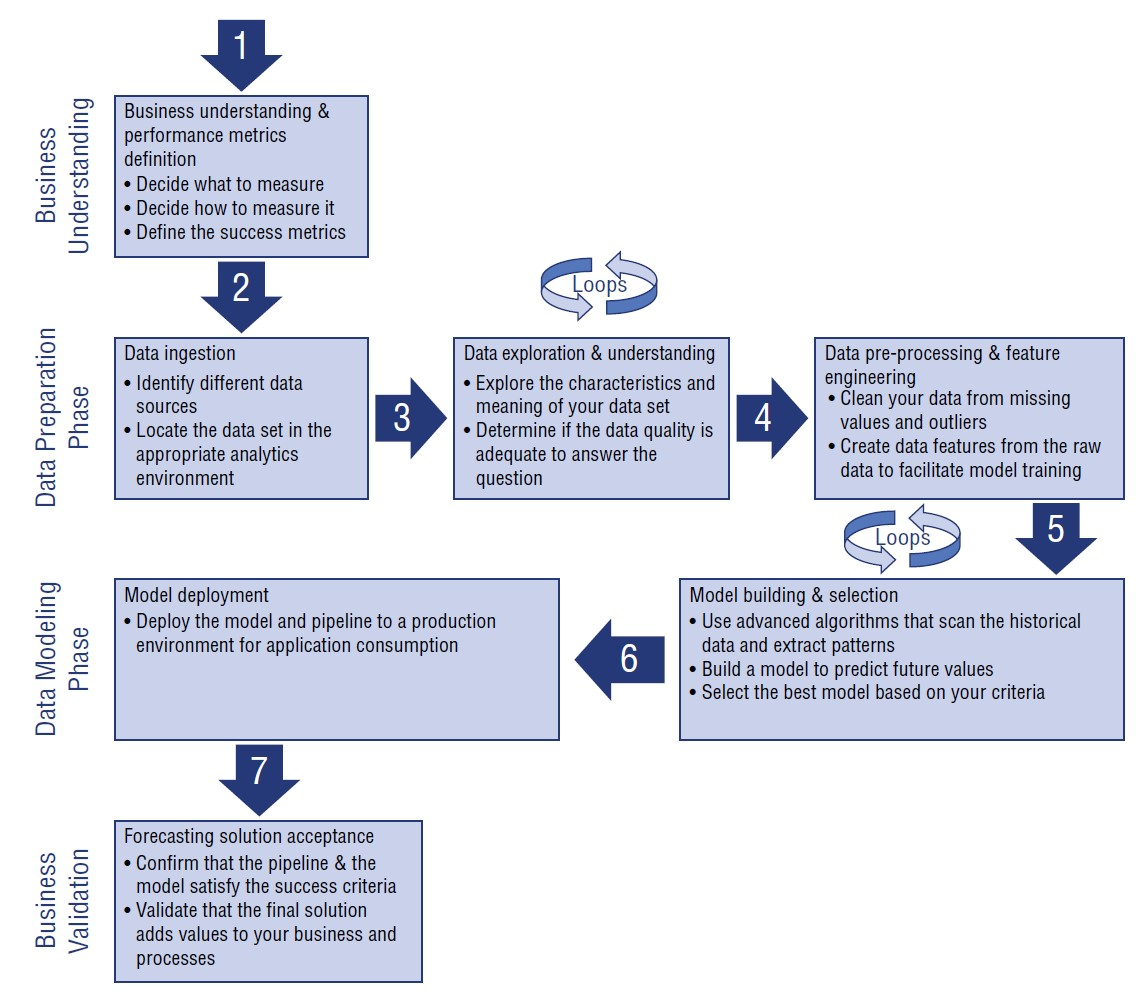

In [5]:
def find_path(name, path):
    import os
    for root, dirs, files in os.walk(path):
        if name in files:
            return os.path.join(root, name)
        
def display_image(img_path):
    from IPython.display import Image
    return Image(filename = img_path, format = 'jpeg',  width = 1000, height = 10)
        
METHOD_IMAGE = 'TS_method.jpg'
METHOD_PATH = r'C:\Users\admin\Pictures'

img_path = find_path(METHOD_IMAGE, METHOD_PATH)
display_image(img_path)


* From Francesca Lazzery's book: Machine Learning for Time Series Forecasting With Python (Wiley - 2020)

In [6]:
# Logger decorator

def timelog(f):
    """ Decorator that allow us to control time and correctness in data_type of output"""
    def wrapper(dataf, *args, **kargs):
        tic = dt.datetime.now()
        result = f(dataf, *args, **kargs)
        toc = dt.datetime.now()
        if isinstance(result, pd.DataFrame) | isinstance(result, pd.Series) : status = 'OK'
        else: status = 'Check the function output'
        logging.info(f"{f.__name__} took {toc - tic} with result size = {result.shape} --> {status}")
        return result
    return wrapper 

****
## 2. Data ingestion
***

>  2.1. Importing data from CSV file   
>  2.2. Importing data from Excel files  
>  2.3. Importing data from Database   
>  2.4. Importing data from URL web-site   
>  2.5. Importing data from JSON files   

In [7]:
# Data-ingestion: basic helper functions

@timelog
def import_from_CSV(path, file_name):
    df =  pd.read_csv(path + file_name, 
                      sep=',', 
                      delimiter=None, 
                      header='infer', 
                      names=None, 
                      index_col=None, 
                      usecols=None)
    return df

@timelog
def import_from_excel(path, file_name):
    df = pd.read_excel(path + file_name,
                       sheet_name=0,
                       header=0,
                       names=None,
                       index_col=None,
                       usecols=None,)
    return df

@timelog
def import_from_database(path, file_name, 
                         table_name, 
                         initial_date, end_date,
                         verbose = 0):
    from sqlalchemy import create_engine
    def db_engine(db_name = PATH_FILE + FILE_NAME, verbose = verbose):
        try:
            if verbose > 0:
                engine = create_engine(f'sqlite:///db/{db_name}', echo = True)
            else: 
                engine = create_engine(f'sqlite:///db/{db_name}', echo = False)
        except (OSError, FileNotFoundError, ConnectionError) as e:
                print (f'Error found: {e}')
    return engine
    
    engine = db_engine(path+file_name, verbose )
    query = f"""SELECT *
            FROM '{table_name}'
            WHERE datetime 
            BETWEEN '{initial_date}' AND '{end_date}' """
                
    return pd.read_sql(query, engine)
                
@timelog
def import_csv_file_from_URL(url, file_name, compressed_zip = True):
    if isinstance(url, str) and isinstance(file_name, str):
        from urllib.request import urlopen
        url_open = urlopen(url)
    else:
        print(f'File {url} or {file_name} is not string')
        
    if compressed_zip:
        from zipfile import ZipFile
        from io import BytesIO
        myzip = ZipFile(BytesIO(url_open.read()))
        df = pd.read_csv(myzip.open(file_name))
        return df
                
@timelog
def import_from_quandl(code, start_date = None):
    import quandl as ql
    ql.ApiConfig.api_key = 'INSERT_HERE_YOUR KEY_TO_ACCESS_QUANDL_API'
    if type(code) is str:
        try:
            return pd.DataFrame(ql.get(code, start_date=start_date))
        except Exception as e:
            print(f'Wrong download: {e}')
    else:
        print(f'code is not string. review.')


In [8]:
# Example:

data = import_csv_file_from_URL('https://archive.ics.uci.edu/ml/machine-learning-databases/00312/dow_jones_index.zip', 'dow_jones_index.data')

11:31:24 - [ INFO] - import_csv_file_from_URL took 0:00:01.338460 with result size = (750, 16) --> OK


In [9]:
data_oil = import_from_quandl('CHRIS/CME_BZ1', start_date=None)
data_TTF = import_from_quandl('CHRIS/ICE_TFM1', start_date=None)
data_HH = import_from_quandl('CHRIS/CME_HH1', start_date=None)

11:31:32 - [ INFO] - import_from_quandl took 0:00:01.699868 with result size = (2374, 8) --> OK
11:31:33 - [ INFO] - import_from_quandl took 0:00:01.168352 with result size = (1913, 11) --> OK
11:31:34 - [ INFO] - import_from_quandl took 0:00:01.283346 with result size = (1778, 8) --> OK




***
## 3. Data Exploration and understanding
***
- Exploring the basic characteristics of the data set 
- Determine if the data quality is adequate to answer the questions

> 1. Basic plotting of the time series
> 2. Boxplot 
> 3. Trend and Seasonality preview
> 4. Outliers preview
> 5. Stationarity basic preview

In [143]:
# Data Exploration: basic helper functions

def ts_univariate_plotting(df_data, window, plot_intervals=False, scale=1.96, plot_anomalies=False):
    from sklearn.metrics import mean_absolute_error
    import statsmodels.api as sm
    df_data.dropna(inplace=True)
    for ts in df_data.columns:
        df = pd.DataFrame(df_data[f'{ts}'], index = df_data.index)
        rolling_mean = df.rolling(window=window).mean()
        fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, figsize=(10,20))

        ax1.set_title(f"{ts}: Prices, moving average and upper/lower bands \n window size = {window}")
        ax1.plot(rolling_mean, "g", label="Rolling mean trend")
        if plot_intervals:
            mae = mean_absolute_error(df[window:], rolling_mean[window:])
            deviation = np.std(df[window:] - rolling_mean[window:])
            lower_bond = rolling_mean - (mae + scale * deviation)
            upper_bond = rolling_mean + (mae + scale * deviation)
            ax1.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
            ax1.plot(lower_bond, "r--")
            if plot_anomalies:
                anomalies = pd.DataFrame(index=df.index, columns=df.columns)
                anomalies[df<lower_bond] = df[df<lower_bond]
                anomalies[df>upper_bond] = df[df>upper_bond]
                ax1.plot(anomalies, "ro", markersize=10)

        ax1.plot(df[window:], label=f"{ts}: Actual values")
        ax1.legend(loc="upper left")
        ax1.grid(True)
        ax2.set_title('Histogram')
        ax2.hist(df, bins=100)
        ax3.set_title(f'{ts}: Boxplot')
        ax3.boxplot(df, vert=False)
        pd.plotting.lag_plot(df, ax=ax4 )
        ax4.set_title(f'{ts}: Lag of returns relation')
        sm.graphics.tsa.plot_acf(df.values.squeeze(), lags=np.arange(1,125), ax=ax5)
        sm.graphics.tsa.plot_pacf(df.values.squeeze(), lags=np.arange(1,125), ax=ax6)
        plt.tight_layout()
    
    
    
def seasonal_decomposition(df):
    from statsmodels.tsa.seasonal import STL
    stl = STL(df, period=125)
    res = stl.fit()
    fig = res.plot()
    return fig

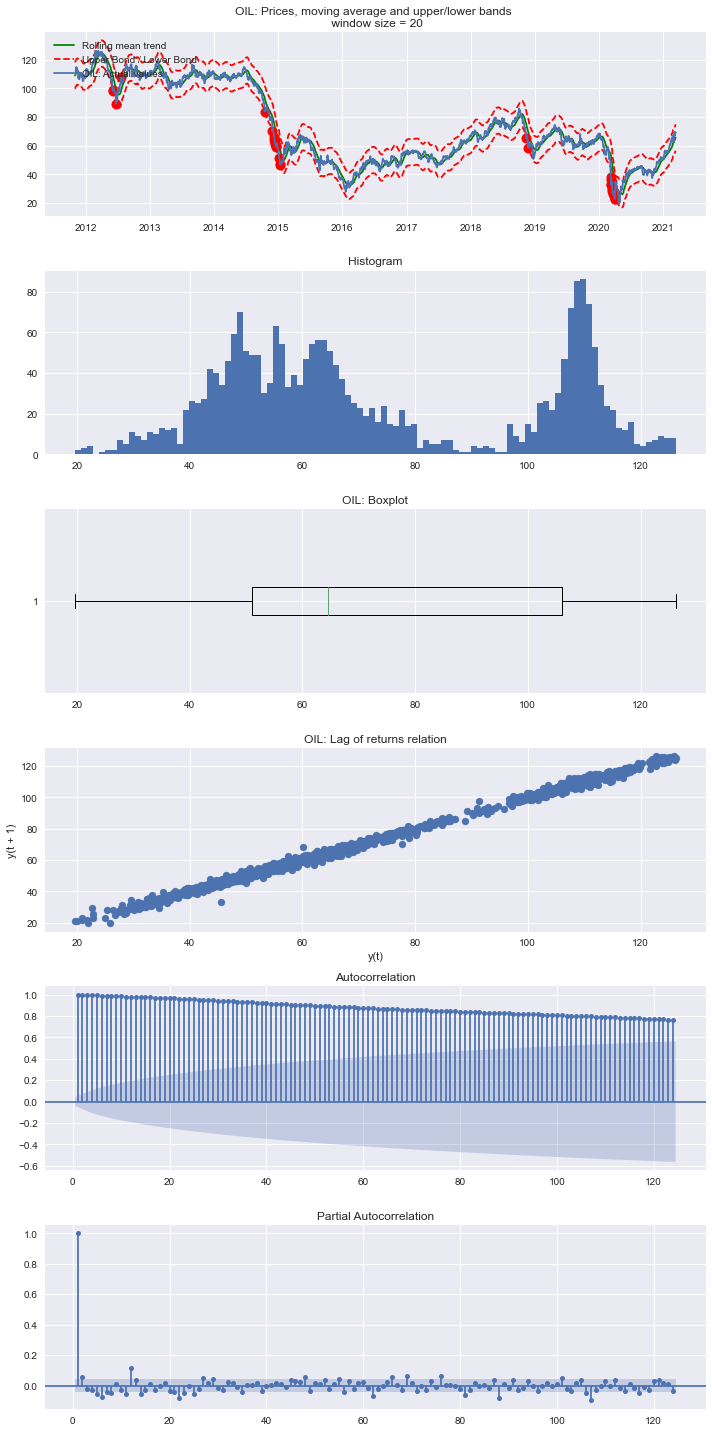

In [144]:

df1 = pd.DataFrame(data_oil.Last, index = data_oil.index)
df1.rename(columns={'Last':'OIL'}, inplace=True)
ts_univariate_plotting(df1, 20, plot_intervals=True, scale=1.96, plot_anomalies=True)

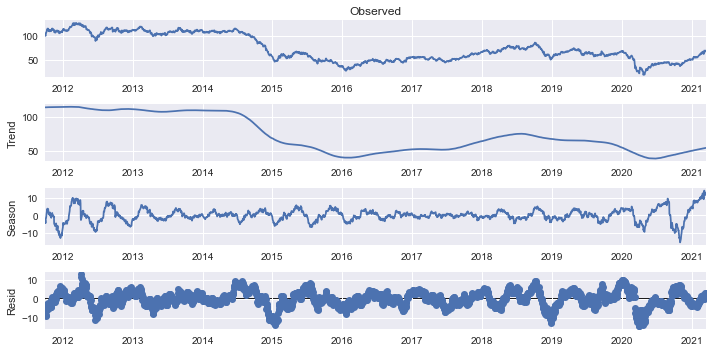

In [145]:
seasonal_decomposition(df1);

***
## 4. Data Preprocessing and Feature Engineering
***
- Clean data set from missing values and outliers
- Create data feautures from the raw data to highlight the model signals

> 1. Data Preprocessing: data cleaning and outliers manipulation
> 2. Feature Engineering: scaling, standarization and power transformations 

In [146]:
# Helper functions for data cleaning


@timelog
def start_pipeline(df):
    df_clean = df.copy()
    return df_clean

@timelog
def clean_na(df):
    df_clean = df.dropna(axis=0)
    return df_clean

@timelog
def fill_na_ffill(df_input):
    df = df_input.select_dtypes(include = ['float64'])
    df_clean = df.fillna(method='ffill')
    return df_clean

@timelog
def fill_na_linear(df_input):
    df = df_input.select_dtypes(include = ['float64'])
    df_clean = df.interpolate(method='linear')
    return df_clean

@timelog
def fill_na_polynomial(df_input):
    df = df_input.select_dtypes(include = ['float64'])
    df_clean = df.interpolate(method='polynomial', order=2)
    return df_clean

@timelog
def fill_na_median(df_input):
    from sklearn.impute import SimpleImputer
    df = df_input.select_dtypes(include = ['float64'])
    imputer = SimpleImputer(missing_values=np.nan, strategy='median')
    imputer.fit(df)
    df_clean = pd.DataFrame(imputer.transform(df.select_dtypes(include = ['float64'])).flatten(), 
                            index = df.index)
    return df_clean

@timelog
def clean_duplicates(df):
    indx = df[df.duplicated(keep='first')].index
    df_clean = df.drop(index=indx)
    return df_clean

@timelog
def clean_zeros(df_input):
    df = df_input.select_dtypes(include = ['float64'])
    indx = df.loc[df.iloc[0] == 0].index
    df_clean = df.drop(index=indx)
    return df_clean

@timelog
def clean_outliers(df_input):
    from scipy import stats
    df = df_input.select_dtypes(include = ['float64'])
    df_clean = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]
    return df_clean

@timelog
def ouliers_impute_linear(df_input):
    from scipy import stats
    df = df_input.select_dtypes(include = ['float64'])
    df = pd.DataFrame(np.where(np.abs(stats.zscore(df)) < 3, df, np.nan),
                      index = df.index, 
                      columns = df.columns)
    df_clean = pd.DataFrame(df.interpolate(method='linear'), 
                            index=df.index, 
                      columns = df.columns).dropna(axis=0)
    return df_clean

@timelog
def ouliers_impute_median(df_input):
    from scipy import stats
    from sklearn.impute import SimpleImputer
    df = df_input.select_dtypes(include = ['float64'])
    
    clean = pd.DataFrame(np.where(np.abs(stats.zscore(df)) < 3, df, np.nan),
                      index = df.index, 
                      columns = df.columns)
    
    median_imputer = SimpleImputer(missing_values=np.nan, strategy="median")
    clean_complete = median_imputer.fit_transform(clean) #.reshape(-1, 1))
    df_clean = pd.DataFrame(clean_complete, index=df.index, 
                      columns = df.columns)
    return df_clean    

In [147]:
# Helper functions for Feature Engineering

@timelog
def absolute_returns(df):
    df_transf = df.select_dtypes(include = ['float64']).diff().dropna()
    return df_transf

@timelog
def relative_returns(df):
    df_transf = df.select_dtypes(include = ['float64']).pct_change().dropna()
    return df_transf

@timelog
def normalized_transformation(df):
    from sklearn import preprocessing
    sc =preprocessing.StandardScaler()
    df_sc = pd.DataFrame(sc.fit_transform(df.select_dtypes(include = ['float64'])),
                         columns=df.select_dtypes(include = ['float64']).columns)
    df[df.select_dtypes(include = ['float64']).columns]=df_sc.values
    return df

@timelog
def minmax_transformation(df):
    mm = MinMaxScaler()
    df_mm = pd.DataFrame(mm.fit_transform(df.select_dtypes(include = ['float64'])),
                         columns=df.select_dtypes(include = ['float64']).columns)
    df[df.select_dtypes(include = ['float64']).columns]=df_mm.values
    return df

@timelog
def power_transformation(df): 
    from sklearn import preprocessing
    df = df.select_dtypes(include = ['float64'])
    pt = preprocessing.PowerTransformer(method='yeo-johnson', standardize=False)
    df_transf = pd.DataFrame(pt.fit_transform(df), 
                             index = df.index, 
                             columns= df.columns)
    return df_transf

@timelog
def boxcox_transformation(df): 
    from sklearn import preprocessing
    pt = preprocessing.PowerTransformer(method='box-cox', standardize=False)
    df_transf = pd.DataFrame(pt.fit_transform(df.select_dtypes(include = ['float64'])).flatten(), 
                             index = df.index, 
                             columns= df.columns)
    return df_transf
    

In [148]:
df = pd.concat([df1, df2, df3],axis = 1)

df_clean = (df.pipe(start_pipeline)
              .pipe(clean_na)
              .pipe(clean_duplicates)
              .pipe(relative_returns)
              .pipe(clean_outliers)
              .pipe(ouliers_impute_median)
              .pipe(power_transformation)
              .pipe(clean_na)
           )

13:21:01 - [ INFO] - start_pipeline took 0:00:00 with result size = (2424, 3) --> OK
13:21:01 - [ INFO] - clean_na took 0:00:00.002996 with result size = (1722, 3) --> OK
13:21:01 - [ INFO] - clean_duplicates took 0:00:00.011019 with result size = (1722, 3) --> OK
13:21:01 - [ INFO] - relative_returns took 0:00:00.003996 with result size = (1721, 3) --> OK
13:21:01 - [ INFO] - clean_outliers took 0:00:00.003015 with result size = (1643, 3) --> OK
13:21:01 - [ INFO] - ouliers_impute_median took 0:00:00.005997 with result size = (1643, 3) --> OK
13:21:01 - [ INFO] - power_transformation took 0:00:00.019038 with result size = (1643, 3) --> OK
13:21:01 - [ INFO] - clean_na took 0:00:00.002001 with result size = (1643, 3) --> OK


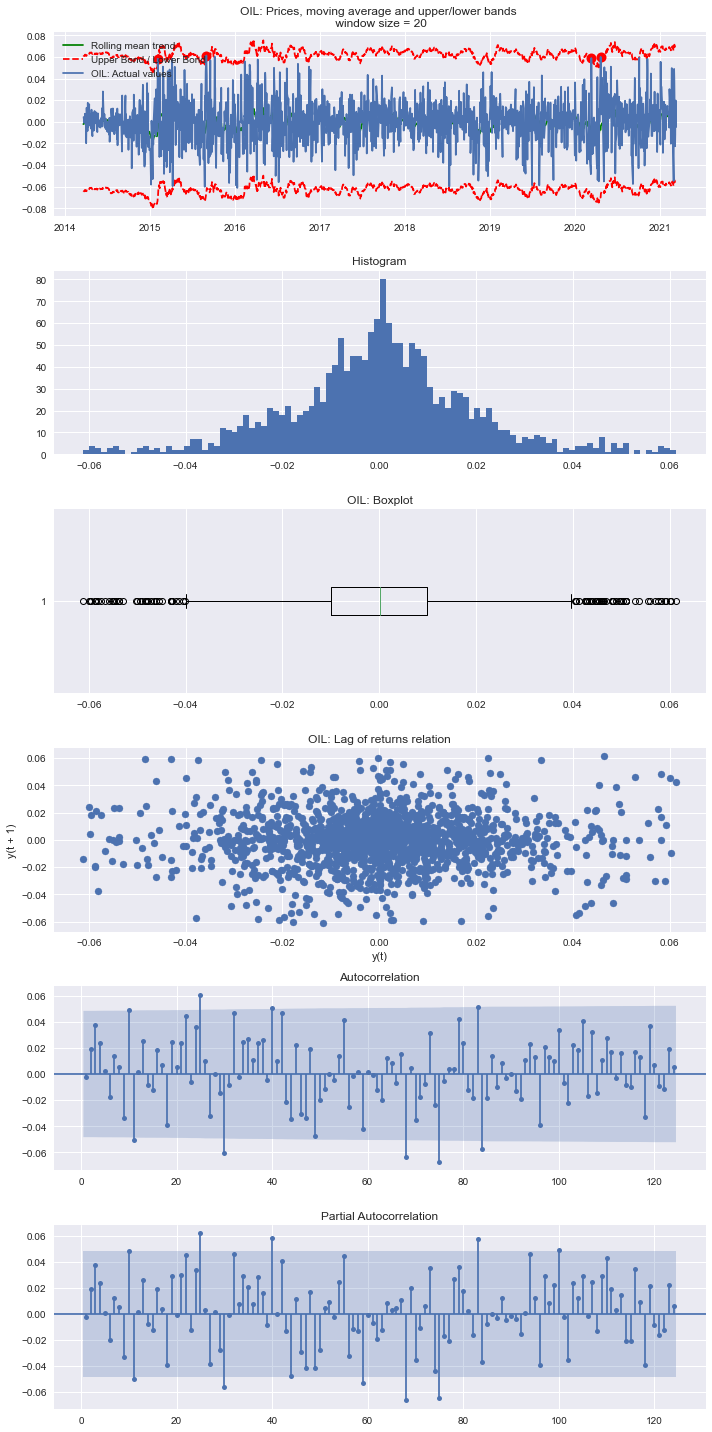

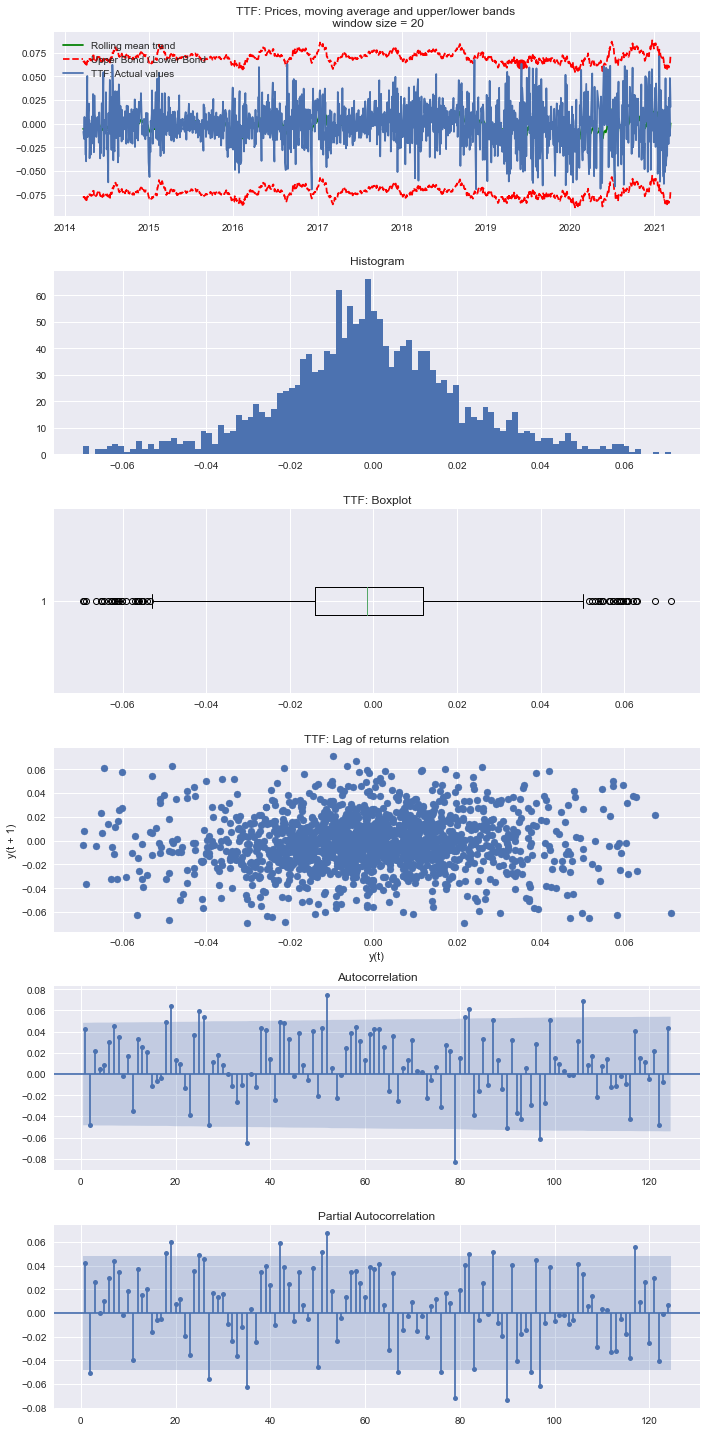

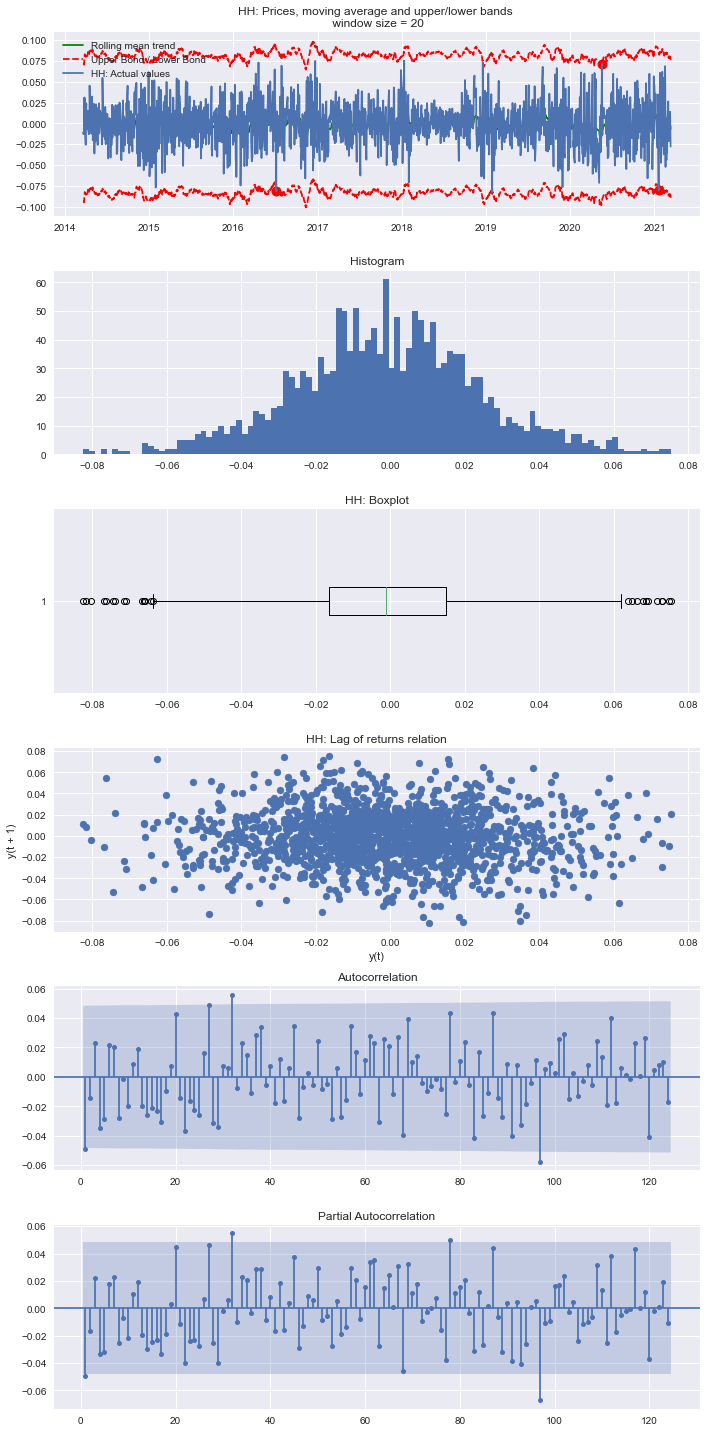

In [149]:
ts_univariate_plotting(df_clean, 20, plot_intervals=True, scale=2.58, plot_anomalies=True) 

***
## 5. Volatility Model training and selection 
***


In order to take into account all these deviations (i.e., leptokurtosis, volatility clustering, and leverage), the `ARCH` (Autoregressive Conditional Heteroscedasticity) Engle (1982) and Bollerslev (1986) proposed the following model:

$$
\sigma^2_t=\alpha_0+\alpha_1u^2_{t-1}+\alpha_2u^2_{t-2}+\cdots...+\alpha_qu^2_{t-q}=\alpha_0+\sum_i^q\alpha_iu^2_{t-i}
$$

where $\alpha_0>0, \alpha_i>0, \text{ and } u_t=\sigma_tz_t$

Later on, Bollerslev (1986) and Taylor (2008) improved the ARCH model by adding lagged conditional variance into the equation and it is referred to as `GARCH` (The Generalized Autoregressive Conditional Heteroscedasticity). The mathematical expression is similar to ARCH except for one term, which is the past values of conditional volatility $\sigma^2$:

$$
\sigma^2_t=\omega+\beta\sigma^2_{t-1}+\alpha u^2_{t-1}
$$

where $\omega$, $\beta$, and $\alpha$ are parameters and have the following restrictions: $\omega$ $>$ 0, $\beta$ $\geq$ 0, and $\alpha$ $\geq$ 0. 

Finally, because not every event leads to the same volatility, it is a necessity to capture this volatility asymmetry. `EGARCH` (the exponential generalized autoregressive conditional heteroskedastic) is one of the models that can successfully consider this asymmetry. The equation is rather complex compared to ARCH and GARCH, but we do not need to worry about that. The equation for EGARCH is: 

$$\text{log}(h_t)=\omega + \sum^p_{j=1}\beta_j \text{log}(h_{t-j})+ \sum^q_{i=1}\alpha_i\frac{|u_{i-1}|}{\sqrt{h_{t-i}}}+\sum^q_{i=1}\gamma_i\frac{u_{t-i}}{\sqrt{h_{t-i}}}
$$

$\omega$ grasps the asymmetric shocks of volatility and $\alpha$ captures the volatility clustering. Thus, asymmetric shocks of volatility and volatility of clustering are captured by the EGARCH model.

In [62]:
df_training = 100 * df_clean.iloc[0: 3*df_clean.shape[0]//4, :].dropna()
df_testing = 100 * df_clean.iloc[3*df_clean.shape[0]//4: , :].dropna()
split_date = df_testing.index[0].strftime("%Y-%m-%d")
split_date

In [63]:
from arch import arch_model

In [93]:
results_egarch=[]
for i in range(len(df_clean.columns)):
    results_egarch.append(arch_model((100*df_clean.iloc[:, i].dropna()),mean='Constant',vol='egarch',dist='Normal').fit(last_obs=split_date, disp='off'))

In [94]:
results_egarch

[                     Constant Mean - EGARCH Model Results                     
 Dep. Variable:                    OIL   R-squared:                       0.000
 Mean Model:             Constant Mean   Adj. R-squared:                  0.000
 Vol Model:                     EGARCH   Log-Likelihood:               -2419.45
 Distribution:                  Normal   AIC:                           4846.89
 Method:            Maximum Likelihood   BIC:                           4867.36
                                         No. Observations:                 1232
 Date:                Sun, Mar 14 2021   Df Residuals:                     1231
 Time:                        12:56:38   Df Model:                            1
                                   Mean Model                                  
                   coef    std err          t      P>|t|       95.0% Conf. Int.
 ------------------------------------------------------------------------------
 mu         -7.1012e-03  4.451e-02     -

***
## 6 and 7. EGarch Volatility Forecasting
***

In [159]:
window_size=10
realized_volatility=[]
for j in df_clean.columns:
    rv=(df_clean[j]).rolling(window_size).std()
    realized_volatility.append(rv)
realized_volatility=pd.DataFrame(realized_volatility).T
realized_volatility.dropna(inplace=True)
realized_volatility

,OIL,TTF,HH
Date,,,
2014-03-06,0.010287,0.019508,0.040196
2014-03-07,0.010881,0.019863,0.040245
2014-03-10,0.011066,0.020780,0.039931
2014-03-11,0.010862,0.020704,0.035738
2014-03-12,0.010929,0.021004,0.033653
...,...,...,...
2021-03-08,0.035080,0.023653,0.019848
2021-03-09,0.032437,0.025224,0.017087
2021-03-10,0.032271,0.027491,0.018002


In [160]:
split_date = df_testing.index[0].strftime("%Y-%m-%d")
split_date

'2019-04-18'

In [161]:
forecast_egarch=[]
for i in range(len(df.columns)):
    forecast_egarch.append(results_egarch[i].forecast(start=split_date).variance[split_date:].mean(axis=1))
    
forecast_egarch=pd.DataFrame(forecast_egarch, index = df_clean.columns).T

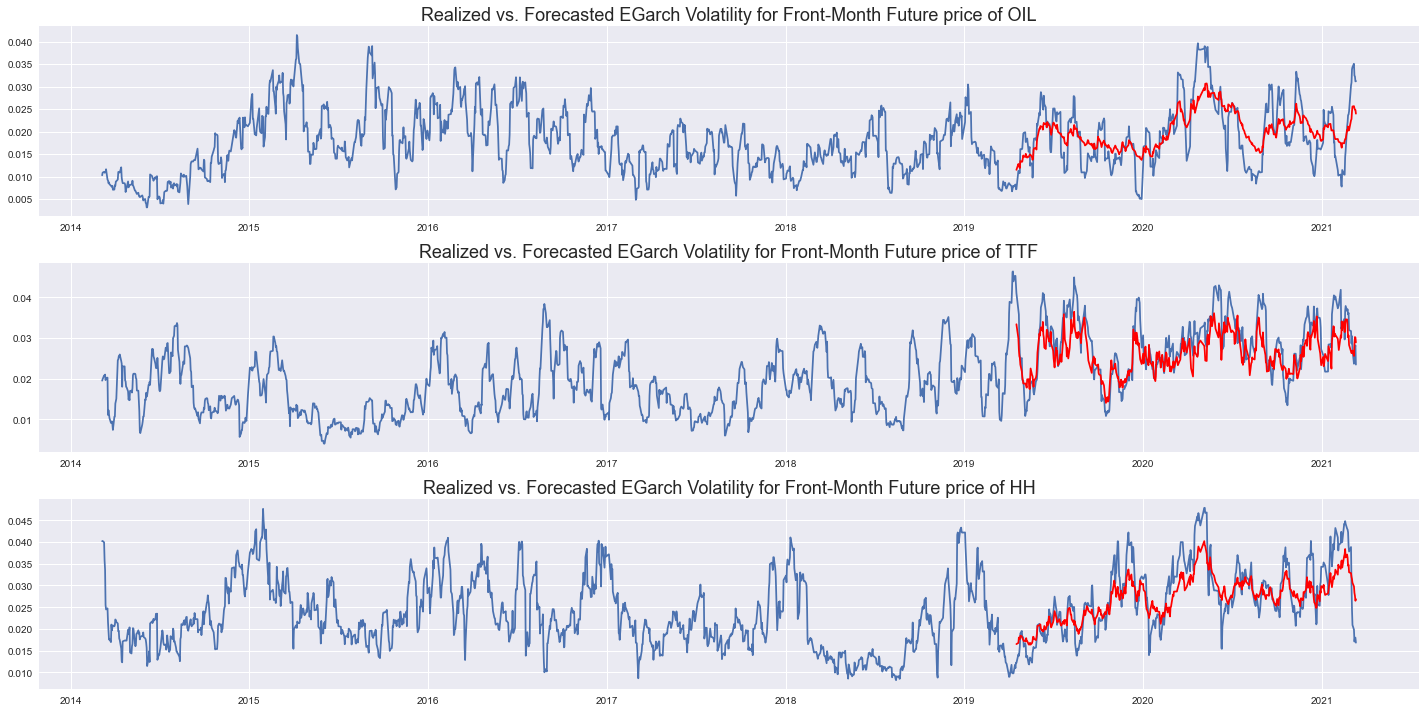

In [162]:
plt.figure(figsize=(20,10))
k=0
for i,j in zip(df_clean.columns,range(len(df_clean.columns))):
    k+=1
    plt.subplot(3,1, k)
    plt.tight_layout()
    plt.plot(realized_volatility[i])
    plt.plot(np.sqrt(forecast_egarch.iloc[:,j])/100, 'r-')
    plt.title(f'Realized vs. Forecasted EGarch Volatility for Front-Month Future price of {i}', fontsize=18)